In [5]:
%load_ext autoreload
%autoreload 2
from evaluation.face_recognition_test import Face_Fecognition_test
from evaluation.ijb_evals import instantiate_list
from omegaconf import OmegaConf
from pathlib import Path
import numpy as np
from evaluation.visualize import (
    plot_dir_far_scores,
    plot_cmc_scores,
    plot_rejection_scores,
)
from scipy.special import loggamma
import numpy as np
from hydra.utils import instantiate
import seaborn as sns
import pandas as pd
from sklearn.datasets import load_iris

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
k = 50
d = 512
d / 2

256.0

In [18]:
log_alpha = (
    loggamma(d / 2)
    + loggamma(d - 1 + 2 * k)
    - k * np.log(2)
    - loggamma(d - 1 + k)
    - loggamma(d / 2 + k)
)

In [19]:
log_alpha

2.1883964526475665

In [20]:
np.exp(log_alpha)

8.920896559070439

In [32]:
from evaluation.open_set_methods.posterior_prob_based import PosteriorProb

kappa = 400
beta = 0.5
class_model = "power"
K = 1772
prob = PosteriorProb(kappa, beta, class_model, K)

In [33]:
prob.kappa_zero

28.097659208567492

In [34]:
prob.shift

0.2913762583597657

In [28]:
prob.log_prior

7.438383530044308

In [31]:
prob.compute_f_kappa_zero(prob.kappa_zero, prob.shift, prob.log_prior, 512)

-3.802513859341161e-14

In [4]:
1

1

/home/erlygin/miniconda/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


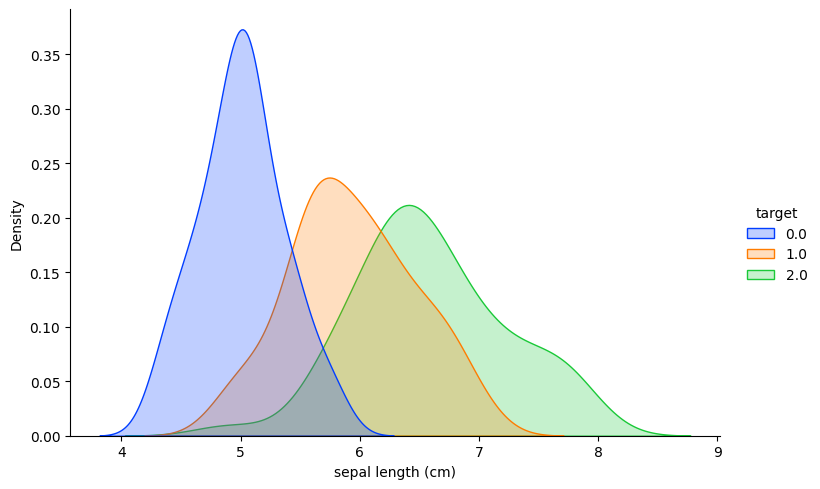

In [3]:
iris = load_iris()
iris = pd.DataFrame(
    data=np.c_[iris["data"], iris["target"]], columns=iris["feature_names"] + ["target"]
)

sns.displot(
    data=iris,
    x="sepal length (cm)",
    hue="target",
    kind="kde",
    fill=True,
    palette=sns.color_palette("bright")[:3],
    height=5,
    aspect=1.5,
)

In [4]:
iris

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2.0
146,6.3,2.5,5.0,1.9,2.0
147,6.5,3.0,5.2,2.0,2.0
148,6.2,3.4,5.4,2.3,2.0


In [2]:
cfg = OmegaConf.load("/app/configs/uncertainty_benchmark/ijb_evals.yaml")
method = cfg.open_set_identification_methods[0]
sampler = instantiate(method.sampler)
evaluation_function = instantiate(method.evaluation_function)
assert evaluation_function is not None
# if cfg.test_dataset.dataset_name == "survFace" and method.use_detector_score:
#     continue
template_pooling = instantiate(method.template_pooling_strategy)

In [3]:
open_set_identification_metrics = instantiate_list(cfg.open_set_identification_metrics)
if "open_set_uncertainty_metrics" in cfg:
    open_set_uncertainty_metrics = instantiate_list(cfg.open_set_uncertainty_metrics)
else:
    open_set_uncertainty_metrics = []

test_dataset = instantiate(cfg.test_dataset)

# create result dirs:
dataset_name = cfg.test_dataset.dataset_name
open_set_identification_result_dir = (
    Path(cfg.exp_dir) / dataset_name / "open_set_identification"
)
open_set_identification_result_dir.mkdir(exist_ok=True, parents=True)

tt = Face_Fecognition_test(
    sampler=sampler,
    evaluation_function=evaluation_function,
    test_dataset=test_dataset,
    embeddings_path=method.embeddings_path,
    template_pooling_strategy=template_pooling,
    use_detector_score=method.use_detector_score,
    use_two_galleries=cfg.use_two_galleries,
    recompute_template_pooling=cfg.recompute_template_pooling,
    open_set_identification_metrics=open_set_identification_metrics,
    closed_set_identification_metrics=None,
    verification_metrics=None,
    open_set_uncertainty_metrics=open_set_uncertainty_metrics,
)

In [4]:
(
    g1_templates_feature,
    g1_template_unc,
    g1_unique_ids,
) = tt.get_template_subsets(tt.test_dataset.g1_templates, tt.test_dataset.g1_ids)

(
    probe_templates_feature,
    probe_template_unc,
    probe_unique_ids,
) = tt.get_template_subsets(tt.test_dataset.probe_templates, tt.test_dataset.probe_ids)

# sample probe feature vectors

probe_templates_feature = tt.sampler(
    probe_templates_feature,
    probe_template_unc,
)

In [5]:
similarity, probe_score = tt.evaluation_function(
    probe_templates_feature,
    probe_template_unc,
    g1_templates_feature,
    g1_template_unc,
)

In [6]:
similarity.shape

(19593, 1, 1772)

In [7]:
gallery_ids = g1_unique_ids
gallery_ids_argsort = np.argsort(gallery_ids)
gallery_ids_sorted = gallery_ids[gallery_ids_argsort]

In [8]:
gallery_ids_sorted_von_mises = np.concatenate(
    [gallery_ids_sorted, [-1]]
)  # last id is for out of gallery


def compute_von_Mises_tar_far(
    kappa,
    beta,
    probe_ids,
    gallery_ids_sorted_von_mises,
    gallery_ids_argsort,
    gallery_ids_sorted,
    similarity,
    present_probe_ids,
):
    selected_probe_ids = probe_ids[present_probe_ids]
    selected_similarity = similarity[present_probe_ids]
    is_seen = np.isin(selected_probe_ids, gallery_ids)
    seen_probe_ids = selected_probe_ids[is_seen]
    mises_maxprob = MisesProb(kappa=kappa, beta=beta)
    all_classes_log_prob = mises_maxprob.compute_all_class_log_probabilities(
        selected_similarity
    )
    all_classes_log_prob = all_classes_log_prob[:, 0, :]

    # make pred
    # sort labels
    all_classes_log_prob[:, :-1] = all_classes_log_prob[:, :-1][:, gallery_ids_argsort]
    predict_id = np.argmax(all_classes_log_prob, axis=-1)
    # far
    far = np.mean(predict_id[~is_seen] != similarity.shape[-1])
    # tar
    tar = np.mean(gallery_ids_sorted_von_mises[predict_id[is_seen]] == seen_probe_ids)

    false_ident_num = np.sum(
        np.logical_and(
            gallery_ids_sorted_von_mises[predict_id[is_seen]] != seen_probe_ids,
            predict_id[is_seen] != similarity.shape[-1],
        )
    )
    most_similar_classes = np.argmax(all_classes_log_prob[:, :-1], axis=-1)[is_seen]
    similar_class = gallery_ids_sorted[most_similar_classes]
    false_ident_num_v2 = np.sum(seen_probe_ids != similar_class)  ## is that right?

    false_accept_num = np.sum(predict_id[~is_seen] != similarity.shape[-1])
    false_reject_num = np.sum(predict_id[is_seen] == similarity.shape[-1])
    return (
        tar,
        far,
        false_ident_num,
        false_ident_num_v2,
        false_accept_num,
        false_reject_num,
    )

In [9]:
present_probe_ids = np.arange(probe_unique_ids.shape[0])
kappa = 540.0
beta = 0.9772372209558107
compute_von_Mises_tar_far(
    kappa,
    beta,
    probe_unique_ids,
    gallery_ids_sorted_von_mises,
    gallery_ids_argsort,
    gallery_ids_sorted,
    similarity,
    present_probe_ids,
)

(0.9445708376421923, 0.010178373475763378, 13, 269, 101, 523)

In [11]:
# from itertools import product
# from tqdm import tqdm

# kappas = np.linspace(100, 1200, 6)
# betas = np.logspace(-0.01, -0.01, num=1)
# print(len(kappas) * len(betas))
# kappa_beta_to_tar_far = {}
# present_probe_ids = np.arange(probe_unique_ids.shape[0])
# for kappa, beta in tqdm(product(kappas, betas), total=len(kappas) * len(betas)):
#     tar, far, _, _, _, _ = compute_von_Mises_tar_far(
#         kappa,
#         beta,
#         probe_unique_ids,
#         gallery_ids_sorted_von_mises,
#         gallery_ids_argsort,
#         gallery_ids_sorted,
#         similarity,
#         present_probe_ids,
#     )
#     # print(f'tar-{tar} at far-{far} with kappa-{kappa} and beta {beta}')
#     kappa_beta_to_tar_far[(kappa, beta)] = (tar, far)

# tars = np.array([kappa_beta_to_tar_far[key][0] for key in kappa_beta_to_tar_far])
# fars = np.array([kappa_beta_to_tar_far[key][1] for key in kappa_beta_to_tar_far])

# far_sort_idx = np.argsort(fars)
# fars = fars[far_sort_idx]
# tars = tars[far_sort_idx]

# a = np.load(
#     "/app/outputs/experiments/open_set_uncertainty_without_thresh/IJBC/open_set_identification/Cosine_recalls_1_rank.npz"
# )

# scores = [(a["fars"], a["recalls"]), (fars, tars)]
# model_names = ["Cosine Sim", "Von Mises Prob"]
# fig = plot_dir_far_scores(
#     scores=scores,
#     names=model_names,
#     y_label=f"Rank 1 Detection & Identification Rate",
#     marker="o",
# )
# fig.savefig(f"dir_plot.png", dpi=300)

### Perform rejection based on uncertanty for a fixed algorithm (fixed threshold or kappa)

First we fix parametr of algorithm, so it have far=0.01

In [12]:
kappa = 540.0
beta = 0.9772372209558107

In [13]:
cosine_far = (
    0.010178373475763378  # far of von Mises at kappa = 540.0, beta = 0.9772372209558107
)
# compute operating threshold τ, which gives neaded far
is_seen = np.isin(probe_unique_ids, gallery_ids)
neg_score = probe_score[~is_seen]
pos_score = probe_score[is_seen]
neg_score_sorted = np.sort(neg_score)[::-1]
if len(neg_score_sorted) == 0:
    thresh = -np.inf
else:
    thresh = neg_score_sorted[max(int((neg_score_sorted.shape[0]) * cosine_far) - 1, 0)]

In [14]:
thresh

0.4121742600157263

In [15]:
mises_maxprob = MisesProb(kappa=kappa, beta=beta)
K = similarity.shape[-1]
thresh_analitic = (
    1
    / kappa
    * (
        np.log(beta / (1 - beta))
        + np.log(K)
        + mises_maxprob.log_uniform_dencity
        - mises_maxprob.log_c
    )
)

In [16]:
thresh_analitic

0.4112618128679961

In [18]:
def compute_cosine_tar_far(
    thresh,
    probe_ids,
    gallery_ids_sorted,
    probe_score,
    similarity,
    present_probe_ids,
    rank=1,
):
    selected_probe_ids = probe_ids[present_probe_ids]
    selected_probe_scores = probe_score[present_probe_ids]
    selected_similarity = similarity[present_probe_ids]
    is_seen = np.isin(selected_probe_ids, gallery_ids_sorted)
    seen_sim: np.ndarray = selected_similarity[is_seen]
    neg_score = selected_probe_scores[~is_seen]
    pos_score = selected_probe_scores[is_seen]
    seen_probe_ids = selected_probe_ids[is_seen]
    most_similar_classes = np.argmax(seen_sim, axis=1)
    similar_class = gallery_ids_sorted[most_similar_classes]
    correct_pos = seen_probe_ids == similar_class
    tar = (
        np.sum(np.logical_and(correct_pos, pos_score > thresh))
        / seen_probe_ids.shape[0]
    )
    far = np.mean(neg_score > thresh)
    false_ident_num = seen_probe_ids.shape[0] - np.sum(correct_pos)
    false_accept_num = np.sum(neg_score > thresh)
    false_reject_num = np.sum(pos_score < thresh)
    return tar, far, false_ident_num, false_accept_num, false_reject_num

In [19]:
similarity_sorted = similarity[:, 0, gallery_ids_argsort]
present_probe_ids = np.arange(probe_unique_ids.shape[0])
compute_cosine_tar_far(
    thresh,
    probe_unique_ids,
    gallery_ids_sorted,
    probe_score,
    similarity_sorted,
    present_probe_ids,
)

(0.944364012409514, 0.01007759750075582, 269, 100, 525)

In [20]:
similarity_sorted = similarity[:, 0, gallery_ids_argsort]
present_probe_ids = np.arange(probe_unique_ids.shape[0])
compute_cosine_tar_far(
    thresh_analitic,
    probe_unique_ids,
    gallery_ids_sorted,
    probe_score,
    similarity_sorted,
    present_probe_ids,
)

(0.9445708376421923, 0.010178373475763378, 269, 101, 523)

In [72]:
mises_maxprob = MisesProb(kappa=kappa, beta=beta)
all_classes_log_prob = mises_maxprob.compute_all_class_log_probabilities(similarity)
all_classes_log_prob = all_classes_log_prob[:, 0, :]
prob_unc = -np.max(all_classes_log_prob, axis=1)
entr_unc = -np.sum(np.exp(all_classes_log_prob) * all_classes_log_prob, axis=1)
scf_unc = -probe_template_unc[:, 0]
simple_maxprob = np.max(similarity[:, 0, :], axis=1)
simple_maxprob_norm = (probe_score + 1) / 2
be_unc = simple_maxprob_norm * (1 - simple_maxprob_norm)
alpha = 0.7

scf_unc_norm = (scf_unc - np.min(scf_unc)) / (np.max(scf_unc) - np.min(scf_unc))
entr_unc_norm = (entr_unc - np.min(entr_unc)) / (np.max(entr_unc) - np.min(entr_unc))
comb_unc = entr_unc_norm * (1 - alpha) + scf_unc_norm * alpha

In [73]:
# import seaborn as sns
# sns.distplot(
#     be_unce,
#     kde=True,
#     norm_hist=True,
#     hist=True,
#     label='maxprob',
# )

In [74]:
fractions = np.linspace(0, 0.2, 10)
probe_sorted_by_scf_unc = np.argsort(scf_unc)
probe_sorted_by_prob_unc = np.argsort(prob_unc)
probe_sorted_by_be_unc = np.argsort(be_unc)
probe_sorted_by_entr_unc = np.argsort(entr_unc)
probe_sorted_by_comb_unc = np.argsort(comb_unc)
methods = ["scf", "be", "prob", "scf+prob", "entr", "comb"]
rejection_tar_far = {name: {"tars": [], "fars": []} for name in methods}
rejection_error_count = {
    name: {"false_accept": [], "false_reject": [], "false_ident": []}
    for name in methods
}
for fraction in tqdm(fractions):
    good_probes_idx_scf = probe_sorted_by_scf_unc[
        : int((1 - fraction) * probe_unique_ids.shape[0])
    ]
    good_probes_idx_prob = probe_sorted_by_prob_unc[
        : int((1 - fraction) * probe_unique_ids.shape[0])
    ]
    good_probes_idx_be = probe_sorted_by_be_unc[
        : int((1 - fraction) * probe_unique_ids.shape[0])
    ]
    good_probes_idx_entr = probe_sorted_by_entr_unc[
        : int((1 - fraction) * probe_unique_ids.shape[0])
    ]
    good_probes_idx_comb = probe_sorted_by_comb_unc[
        : int((1 - fraction) * probe_unique_ids.shape[0])
    ]
    (
        scf_tar,
        scf_far,
        scf_false_ident_num,
        scf_false_accept_num,
        scf_false_reject_num,
    ) = compute_cosine_tar_far(
        thresh,
        probe_unique_ids,
        gallery_ids_sorted,
        probe_score,
        similarity_sorted,
        good_probes_idx_scf,
    )
    (
        be_tar,
        be_far,
        be_false_ident_num,
        be_false_accept_num,
        be_false_reject_num,
    ) = compute_cosine_tar_far(
        thresh,
        probe_unique_ids,
        gallery_ids_sorted,
        probe_score,
        similarity_sorted,
        good_probes_idx_be,
    )
    rejection_tar_far["scf"]["tars"].append(scf_tar)
    rejection_tar_far["scf"]["fars"].append(scf_far)
    rejection_error_count["scf"]["false_accept"].append(scf_false_accept_num)
    rejection_error_count["scf"]["false_reject"].append(scf_false_reject_num)
    rejection_error_count["scf"]["false_ident"].append(scf_false_ident_num)
    rejection_tar_far["be"]["tars"].append(be_tar)
    rejection_tar_far["be"]["fars"].append(be_far)
    rejection_error_count["be"]["false_accept"].append(be_false_accept_num)
    rejection_error_count["be"]["false_reject"].append(be_false_reject_num)
    rejection_error_count["be"]["false_ident"].append(be_false_ident_num)

    (
        prob_tar,
        prob_far,
        _,
        prob_false_ident_num,
        prob_false_accept_num,
        prob_false_reject_num,
    ) = compute_von_Mises_tar_far(
        kappa,
        beta,
        probe_unique_ids,
        gallery_ids_sorted_von_mises,
        gallery_ids_argsort,
        gallery_ids_sorted,
        similarity,
        good_probes_idx_prob,
    )
    (
        entr_tar,
        entr_far,
        _,
        entr_false_ident_num,
        entr_false_accept_num,
        entr_false_reject_num,
    ) = compute_von_Mises_tar_far(
        kappa,
        beta,
        probe_unique_ids,
        gallery_ids_sorted_von_mises,
        gallery_ids_argsort,
        gallery_ids_sorted,
        similarity,
        good_probes_idx_entr,
    )
    (
        comb_tar,
        comb_far,
        _,
        comb_false_ident_num,
        comb_false_accept_num,
        comb_false_reject_num,
    ) = compute_von_Mises_tar_far(
        kappa,
        beta,
        probe_unique_ids,
        gallery_ids_sorted_von_mises,
        gallery_ids_argsort,
        gallery_ids_sorted,
        similarity,
        good_probes_idx_comb,
    )
    rejection_tar_far["prob"]["tars"].append(prob_tar)
    rejection_tar_far["prob"]["fars"].append(prob_far)
    rejection_error_count["prob"]["false_accept"].append(prob_false_accept_num)
    rejection_error_count["prob"]["false_reject"].append(prob_false_reject_num)
    rejection_error_count["prob"]["false_ident"].append(prob_false_ident_num)

    rejection_error_count["entr"]["false_accept"].append(entr_false_accept_num)
    rejection_error_count["entr"]["false_reject"].append(entr_false_reject_num)
    rejection_error_count["entr"]["false_ident"].append(entr_false_ident_num)

    rejection_error_count["comb"]["false_accept"].append(comb_false_accept_num)
    rejection_error_count["comb"]["false_reject"].append(comb_false_reject_num)
    rejection_error_count["comb"]["false_ident"].append(comb_false_ident_num)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:42<00:00, 10.29s/it]


In [75]:
1

1

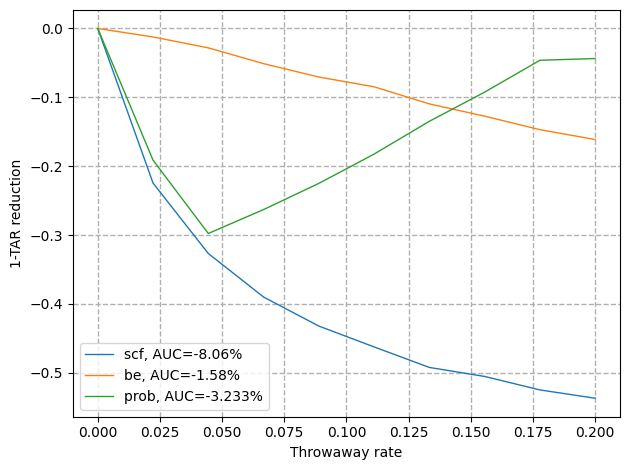

In [76]:
from evaluation.visualize import plot_rejection_scores

scores = []
names = []
for method_name in rejection_tar_far:
    tars = rejection_tar_far[method_name]["tars"]
    tars = np.array(tars)
    if len(tars) == 0:
        continue
    scores.append((fractions, ((1 - tars) - (1 - tars[0])) / (1 - tars[0])))
    names.append(method_name)
fig = plot_rejection_scores(
    scores=scores,
    names=names,
    y_label=f"1-TAR reduction",
)
fig.savefig(f"tar_rejection.png", dpi=300)

In [77]:
1

1

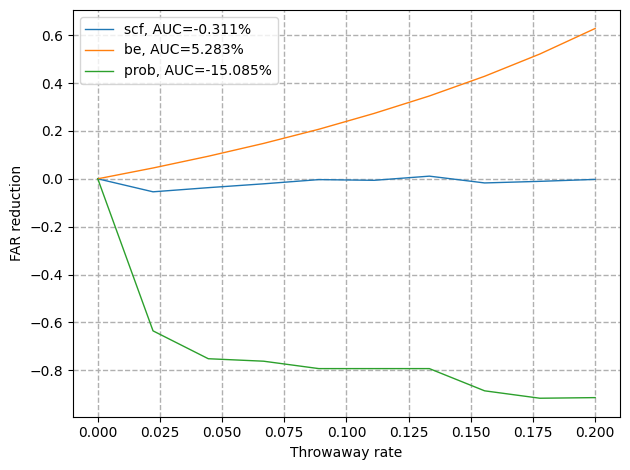

In [78]:
from evaluation.visualize import plot_rejection_scores

scores = []
names = []
for method_name in rejection_tar_far:
    fars = rejection_tar_far[method_name]["fars"]
    fars = np.array(fars)
    if len(fars) == 0:
        continue
    scores.append((fractions, ((fars) - (fars[0])) / (fars[0])))
    names.append(method_name)
fig = plot_rejection_scores(
    scores=scores,
    names=names,
    y_label=f"FAR reduction",
)
fig.savefig(f"tar_rejection.png", dpi=300)

### Let's see how number of different error types changes

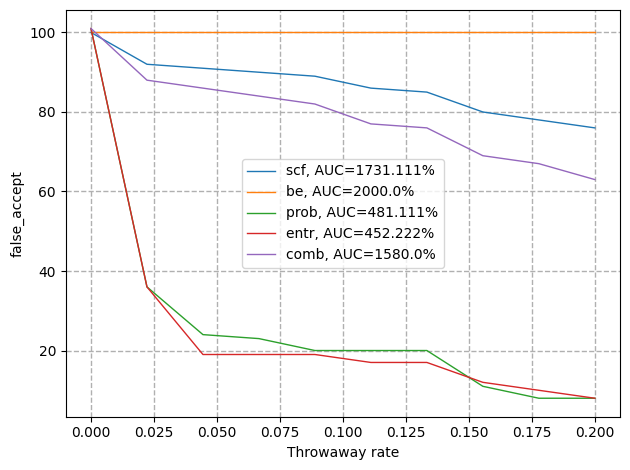

In [79]:
from evaluation.visualize import plot_rejection_scores

scores = []
names = []
for method_name in rejection_error_count:
    false_accept = rejection_error_count[method_name]["false_accept"]
    false_accept = np.array(false_accept)
    if len(false_accept) == 0:
        continue
    scores.append((fractions, false_accept))
    names.append(method_name)
fig = plot_rejection_scores(
    scores=scores,
    names=names,
    y_label=f"false_accept",
)
fig.savefig(f"false_accept.png", dpi=300)

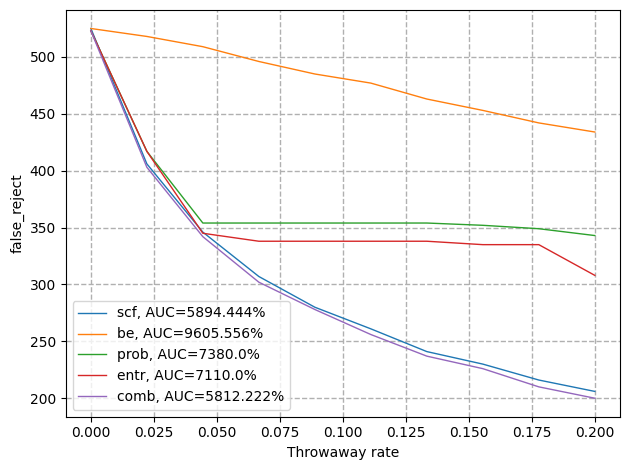

In [80]:
from evaluation.visualize import plot_rejection_scores

scores = []
names = []
for method_name in rejection_error_count:
    false_reject = rejection_error_count[method_name]["false_reject"]
    false_reject = np.array(false_reject)
    if len(false_reject) == 0:
        continue
    scores.append((fractions, false_reject))
    names.append(method_name)
fig = plot_rejection_scores(
    scores=scores,
    names=names,
    y_label=f"false_reject",
)
fig.savefig(f"false_reject.png", dpi=300)

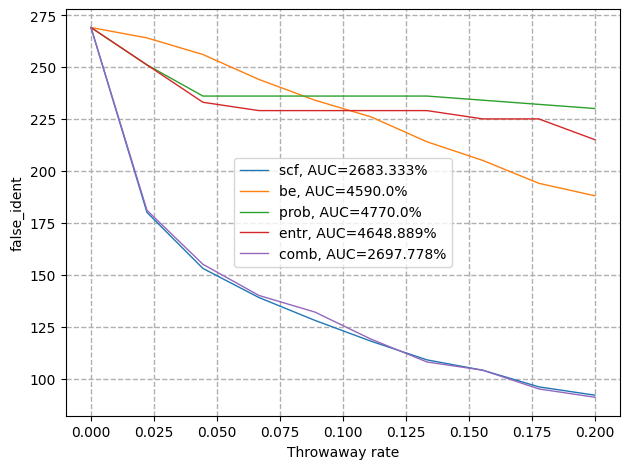

In [81]:
from evaluation.visualize import plot_rejection_scores

scores = []
names = []
for method_name in rejection_error_count:
    false_ident = rejection_error_count[method_name]["false_ident"]
    false_ident = np.array(false_ident)
    if len(false_ident) == 0:
        continue
    scores.append((fractions, false_ident))
    names.append(method_name)
fig = plot_rejection_scores(
    scores=scores,
    names=names,
    y_label=f"false_ident",
)
fig.savefig(f"false_ident.png", dpi=300)

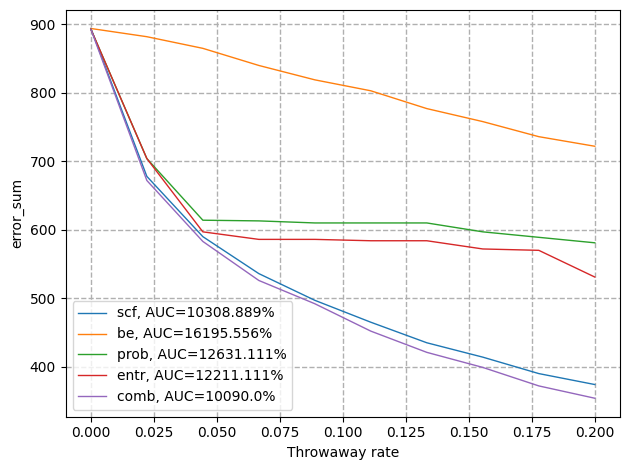

In [82]:
from evaluation.visualize import plot_rejection_scores

scores = []
names = []
for method_name in rejection_error_count:
    false_ident = rejection_error_count[method_name]["false_ident"]
    false_ident = np.array(false_ident)
    false_reject = rejection_error_count[method_name]["false_reject"]
    false_reject = np.array(false_reject)
    false_accept = rejection_error_count[method_name]["false_accept"]
    false_accept = np.array(false_accept)
    if len(false_ident) == 0:
        continue
    scores.append((fractions, false_accept + false_ident + false_reject))
    names.append(method_name)
fig = plot_rejection_scores(
    scores=scores,
    names=names,
    y_label=f"error_sum",
)
fig.savefig(f"error_sum.png", dpi=300)

In [69]:
false_accept

array([101,  36,  19,  19,  19,  17,  17,  12,  10,   8])

In [70]:
method_name

'entr'